In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [105]:
df = pd.read_csv('schedulenets.csv')
df

,updatedAt,Date,Time,block_1
0,2018-11-06 17:31:06,2018-11-06,17:31:06,372.000000
1,2018-11-05 12:53:55,2018-11-05,12:53:55,372.000000
2,2018-11-12 17:16:58,2018-11-12,17:16:58,373.000000
3,2018-11-11 16:58:16,2018-11-11,16:58:16,373.000000
4,2018-11-13 16:52:33,2018-11-13,16:52:33,412.874368
...,...,...,...,...
10538,2021-06-11 09:30:31,2021-06-11,09:30:31,200.000000
10539,2021-06-11 04:27:02,2021-06-11,04:27:02,546.000000
10540,2021-06-11 06:07:02,2021-06-11,06:07:02,466.000000
10541,2021-06-11 08:30:03,2021-06-11,08:30:03,546.000000


In [88]:
df.head()

,updatedAt,Date,Time,block_1
0,2018-11-06 17:31:06,2018-11-06,17:31:06,372.000000
1,2018-11-05 12:53:55,2018-11-05,12:53:55,372.000000
2,2018-11-12 17:16:58,2018-11-12,17:16:58,373.000000
3,2018-11-11 16:58:16,2018-11-11,16:58:16,373.000000
4,2018-11-13 16:52:33,2018-11-13,16:52:33,412.874368


In [89]:
df['time'] = pd.to_datetime(df['updatedAt'])

df['Date'] = df['time'].dt.date
df['Time'] = df['time'].dt.strftime('%H:%M')
df['Voltage']=df['block_1']

df = df[[ 'Date', 'Time','Voltage']]

In [90]:
df['Time_Intervals'] = df['Time'].apply(lambda x: f"{x[:2]}:{int(x[3:]) // 15 * 15:02d} to {x[:2]}:{(int(x[3:]) // 15 + 1) * 15:02d}")
df['Average_Voltage'] = df.groupby('Time_Intervals')['Voltage'].transform('mean')

df = df.groupby(['Date', 'Time_Intervals']).agg({'Average_Voltage': 'mean'}).reset_index()

df = df[[ 'Date', 'Time_Intervals','Average_Voltage']]
# df.to_csv('voltage_with_Intervals.csv', index=False) 
df

,Date,Time_Intervals,Average_Voltage
0,2018-11-05,12:45 to 12:60,417.272665
1,2018-11-05,17:30 to 17:45,407.169412
2,2018-11-06,17:30 to 17:45,407.169412
3,2018-11-10,16:45 to 16:60,386.672865
4,2018-11-11,16:45 to 16:60,386.672865
...,...,...,...
6540,2021-06-11,04:15 to 04:30,391.285290
6541,2021-06-11,06:00 to 06:15,401.741830
6542,2021-06-11,08:30 to 08:45,401.910695
6543,2021-06-11,09:00 to 09:15,397.025748


In [91]:
# Convert Date to datetime if it's not already in the correct format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the time from Time_Intervals
df['Time'] = df['Time_Intervals'].str.extract(r'(\d{2}:\d{2})', expand=False)

# Concatenate Date and Time to create Datetime
df['Datetime'] = df['Date'].astype(str) + ' ' + df['Time']

# Convert Datetime to datetime format
df['ds'] = pd.to_datetime(df['Datetime'])

# Set Datetime as the index
# df.set_index('Datetime', inplace=True)


df['y'] = df['Average_Voltage']

# Drop unnecessary columns if needed
df.drop(['Date', 'Time_Intervals', 'Time','Average_Voltage','Datetime'], axis=1, inplace=True)

# Display the modified DataFrame
df


,ds,y
0,2018-11-05 12:45:00,417.272665
1,2018-11-05 17:30:00,407.169412
2,2018-11-06 17:30:00,407.169412
3,2018-11-10 16:45:00,386.672865
4,2018-11-11 16:45:00,386.672865
...,...,...
6540,2021-06-11 04:15:00,391.285290
6541,2021-06-11 06:00:00,401.741830
6542,2021-06-11 08:30:00,401.910695
6543,2021-06-11 09:00:00,397.025748


In [92]:
train=df.iloc[:len(df)-365]
test=df.iloc[len(df)-365:]

In [93]:
# Create and fit the model
model = Prophet()
model.fit(train)

11:32:51 - cmdstanpy - INFO - Chain [1] start processing
11:32:53 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
# Create a dataframe to hold the future values to be predicted
future = model.make_future_dataframe(periods=365, freq='15min')

In [95]:
# Make predictions
forecast = model.predict(future)

In [96]:
# Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds        yhat  yhat_lower  yhat_upper
6540 2021-04-18 07:45:00  398.137781  367.652770  426.112037
6541 2021-04-18 08:00:00  396.880312  367.582562  426.445320
6542 2021-04-18 08:15:00  395.164779  369.382017  425.822628
6543 2021-04-18 08:30:00  393.083919  363.880820  422.441375
6544 2021-04-18 08:45:00  390.745520  362.601337  420.918978


In [97]:
test.tail()

,ds,y
6540,2021-06-11 04:15:00,391.285290
6541,2021-06-11 06:00:00,401.741830
6542,2021-06-11 08:30:00,401.910695
6543,2021-06-11 09:00:00,397.025748
6544,2021-06-11 09:30:00,398.415216


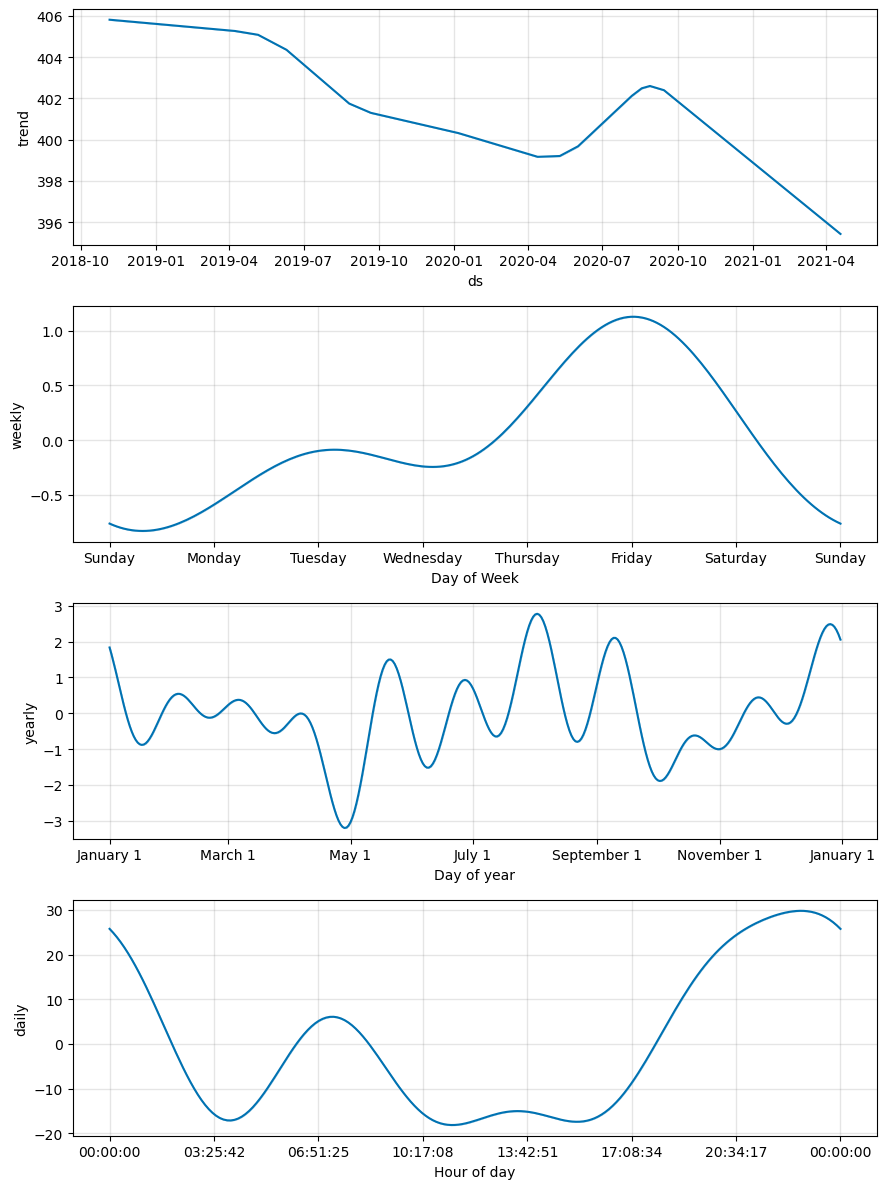

In [98]:
fig2 = model.plot_components(forecast)

In [99]:
plot_plotly(model ,forecast)

In [100]:
from statsmodels.tools.eval_measures import rmse

In [101]:
predictions = forecast.iloc[-365:]['yhat']

In [102]:
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  32.09494145025966
Mean Value of Test Dataset: 399.72245587770675


In [103]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse=rmse(predictions,test['y'])
# Calculate the mean of the test data
mean_value = test['y'].mean()

# Calculate the accuracy in percentage
accuracy = (1 - (rmse / mean_value)) * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 91.97%
